<h1> BrainStation Capstone Project</h1>

<b>Is the song "hot enough" for Billboard Hot100 🔥</b>
<br> Predicing the probability of a song reaching the Billboard Hot100 chart.</br>

Author: Hailey Lee
<br>Contact: ejlee.hailey@gmail.com
<br>Date: July 5, 2022

---

# Other Models for Main Dataset

This section will cover a few more models to test on our main dataset (without lyrics), specifically [K Nearest Neighbors](#knn) and [Support Vector Machine](#svm). While these scores are great, we are not using these as our main method of performance measures due to lack of interpretability. Also, both these models are sensitive to scale, so we will fit the data through a Standard Scaler and through combined scalers.

#### Score Summary
| Model | Parameters | Train Set Accuracy | Test Set Accuracy |
|:------|:-----------|:------------------:|:-----------------:|
| K Nearest Neighbors | Default, Standard Scaler | 87.2% | 81.1% |
| K Nearest Neighbors with Cross Validation | max_depth=22, Standard Scaler | 82.9% | 81.8% | 
| K Nearest Neighbors with GridSearch | max_depth=15, combined scalers | 84.1% | 83.5% |
| SVM, kernel='linear'| Default, Standard Scaler | 81.8% | 81.8% |
| SVM, kernel='rbf'| Default, Standard Scaler | 88.5% | 86.4% |
| SVM, kernel='poly'| Default, Standard Scaler | 88.3% | 84.3% |
| SVM, kernel='sigmoid'| Default, Standard Scaler | 71.6% | 73.0% |
| SVM, kernel='poly' with GridSearch | Combined Scaler | 86.8% | 85.2% |

---

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from tempfile import mkdtemp
cachedir = mkdtemp()

# ignore warning messages
import warnings
warnings.filterwarnings("ignore")

In [22]:
songs_df = pd.read_csv('capstone_dataset_clean.csv')

In [23]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  int64  
 2   billboard_month    13807 non-null  int64  
 3   peak_position      13807 non-null  int64  
 4   weeks_on_chart     13807 non-null  int64  
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13807 non-null  object 
 8   artist_popularity  13807 non-null  int64  
 9   artist_followers   13807 non-null  int64  
 10  song               13807 non-null  object 
 11  track_uri          13807 non-null  object 
 12  track_popularity   13807 non-null  int64  
 13  album_name         13807 non-null  object 
 14  release_year       13807 non-null  int64  
 15  release_month      13807 non-null  int64  
 16  duration_ms        138

In [24]:
# drop non-numeric and billboard exclusive
songs_df = songs_df.drop(columns=['artist', 'feat_artist', 'artist_uri', 'song', 'track_uri','album_name', 'billboard_year',
                                  'peak_position', 'weeks_on_chart','billboard_month'])

In [25]:
# assign target and features

X = songs_df.drop(columns='billboard')
y = songs_df['billboard']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (13807, 33)
Shape of y: (13807,)


In [26]:
X.columns

Index(['artist_popularity', 'artist_followers', 'track_popularity',
       'release_year', 'release_month', 'duration_ms', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'major_label', 'genre_pop', 'genre_screen', 'genre_hiphop',
       'genre_punk', 'genre_blues', 'genre_country', 'genre_rnb', 'genre_rock',
       'genre_latin', 'genre_dance', 'genre_indie', 'genre_elect',
       'genre_gospel', 'genre_chill'],
      dtype='object')

In [27]:
# train test split 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 15,
                                                    stratify = y)

---
### K Nearest Neighbors<a class="anchor" id="knn"></a>

KNN, or K Nearest Neighbors, is a supervised machine learning algorithm that can draw non-linear boundaries to classify data. Classification is determined by the proximity of the data point's $k$ neighbors, a hyperparameter we can set to optimize the model. Because the model is sensitive to distance, we need to ensure that the data is scaled before fitting.

In [28]:
# instantiate
scaler = StandardScaler()

# fit train set
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We used the Standard Scaler here, but we will try to combine scalers as we did in Logistic Regression (refer to 'Capstone Project - Logistic Regression' notebook). We will run the model with default parameters first (5 neighbors):

In [29]:
# instantiate
KNN_model = KNeighborsClassifier()   # default 5 neighbors

# fit on train set
KNN_model.fit(X_train_scaled, y_train)

# score on train and test sets 
print(f'Train set accuracy: {round(KNN_model.score(X_train_scaled, y_train)*100,1)}%')
print(f'Test set accuracy: {round(KNN_model.score(X_test_scaled, y_test)*100,1)}%')

Train set accuracy: 87.2%
Test set accuracy: 81.1%


This is a great starting point. There is slight overfitting -- we can try to adjust the hyperparameters for this.

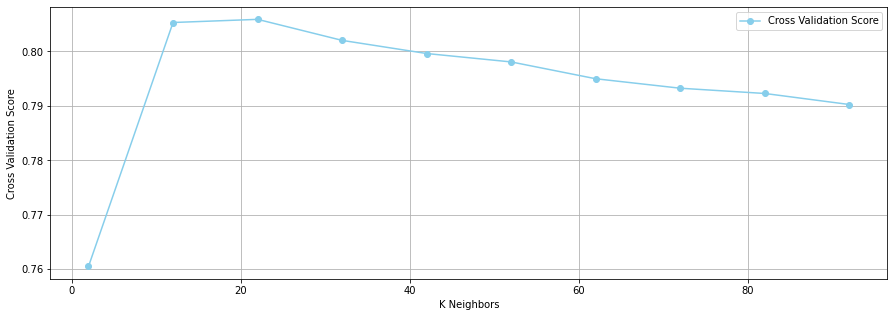

In [30]:
# find the average cross val scores across different parameters (n_neighbors)

cross_validation_scores = []

neighbors = range(2,100,10)

#Do some cross validation
for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    
    # mean of cross val scores
    cv_score = np.mean(cross_val_score(model, X_train_scaled, y_train, cv = 5))
    
    # append to empty list
    cross_validation_scores.append(cv_score)
    
plt.figure(figsize=(15,5))
plt.plot(neighbors, cross_validation_scores,label="Cross Validation Score",marker='o', color='skyblue')
plt.xlabel('K Neighbors')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.legend()
plt.show()

From the graph above, it looks like 22 neighbors is the optimal point.

In [14]:
# re-run the model
KNN_model = KNeighborsClassifier(n_neighbors=22)
KNN_model.fit(X_train_scaled, y_train)
print(f'Train set accuracy: {round(KNN_model.score(X_train_scaled, y_train)*100,1)}%')
print(f'Test set accuracy: {round(KNN_model.score(X_test_scaled, y_test)*100,1)}%')

Train set accuracy: 82.9%
Test set accuracy: 81.8%


Our scores improved slightly. But we will try and run the model with combined scalers this time.

In [31]:
# assign columns for StandardScaler()
std_cols = ['artist_popularity', 'track_popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'valence',
           'tempo'] 

# create a pipeline
std_cols_transform = Pipeline([('scaler', StandardScaler())], memory=cachedir)

# assign columns for MinMaxScaler()
mm_cols = ['artist_followers', 'release_year', 'release_month', 'key', 'mode', 'speechiness', 'acousticness',
           'instrumentalness', 'liveness', 'time_signature', 'major_label', 'genre_pop', 'genre_screen', 'genre_hiphop',
          'genre_punk', 'genre_blues', 'genre_country', 'genre_rnb', 'genre_rock', 'genre_latin', 'genre_dance', 
           'genre_indie', 'genre_elect', 'genre_gospel', 'genre_chill']

# create a pipeline
mm_cols_transform = Pipeline([('scaler', MinMaxScaler())], memory=cachedir)

# instantiate ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[('standard', std_cols_transform, std_cols),
                  ('minmax', mm_cols_transform, mm_cols)])

# set up pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

# run a grid search
param_grid = [{
    'model__n_neighbors': [5,10,15,20,25,30,35],
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid, cv=5)

# fit train set
fittedgrid = grid.fit(X_train, y_train)

In [35]:
fittedgrid.best_params_

{'model__n_neighbors': 15}

In [34]:
print(f'Train set accuracy: {round(fittedgrid.score(X_train, y_train)*100,1)}%')
print(f'Train set accuracy: {round(fittedgrid.score(X_test, y_test)*100,1)}%')

Train set accuracy: 84.1%
Train set accuracy: 83.5%


By combining our scalers and optimizing the hyperparameter to 15 neighbors, we achieved our best accuracy score of 83.5% on our test set.

---
### Support Vector Machines<a class="anchor" id="svm"></a>

SVM's (or Support Vector Machines) are also Machine Learning classifiers that tries to maximize the *distance* (or margin) between the decision boundary and the data points. How strict we want this to be can be adjusted with the $C$ parameter. What is also unique about SVM models is that there are other kernels that can classify *non-linear* data. 

We will fit the data on different kernels using Standard Scaler:

In [38]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for kernel in kernels:
    model = SVC(kernel=kernel)
    model.fit(X_train_scaled, y_train)
    print(f'Kernel: {kernel}')
    print(f'Train set accuracy: {round(model.score(X_train_scaled, y_train)*100,1)}%')
    print(f'Test set accuracy: {round(model.score(X_test_scaled, y_test)*100,1)}%')
    print('---------------------------------')

Kernel: linear
Train set accuracy: 81.8%
Test set accuracy: 81.8%
---------------------------------
Kernel: rbf
Train set accuracy: 88.5%
Test set accuracy: 86.4%
---------------------------------
Kernel: poly
Train set accuracy: 88.3%
Test set accuracy: 84.3%
---------------------------------
Kernel: sigmoid
Train set accuracy: 71.6%
Test set accuracy: 73.0%
---------------------------------


Now we will try to run a GridSearch with combined scalers and see which kernel gives us the best performance.

In [39]:
# set up pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC())
])

# run a grid search
param_grid = [{
    'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid, cv=5)

# fit train set
fittedgrid = grid.fit(X_train, y_train)

In [40]:
# Best estimator object
fittedgrid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standard',
                                                  Pipeline(memory='C:\\Users\\eunji\\AppData\\Local\\Temp\\tmpq35ouzb_',
                                                           steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['artist_popularity',
                                                   'track_popularity',
                                                   'duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'valence',
                                                   'tempo']),
                                                 ('minmax',
                                                  Pipeline(memory='C:\\Users\\eunji\\AppData\\Loca...
                                                   'release_year',
                                                   'release_month', 'key',
                                                   'mode', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'time_signature',
                                                   'major_label', 'genre_pop',
                                                   'genre_screen',
                                                   'genre_hiphop', 'genre_punk',
                                                   'genre_blues',
                                                   'genre_country', 'genre_rnb',
                                                   'genre_rock', 'genre_latin',
                                                   'genre_dance', 'genre_indie',
                                                   'genre_elect',
                                                   'genre_gospel',
                                                   'genre_chill'])])),
                ('model', SVC(kernel='poly'))])

In [41]:
fittedgrid.best_params_

{'model__kernel': 'poly'}

In [42]:
print(f'Train set accuracy: {round(fittedgrid.score(X_train, y_train)*100,1)}%')
print(f'Train set accuracy: {round(fittedgrid.score(X_test, y_test)*100,1)}%')

Train set accuracy: 86.8%
Train set accuracy: 85.2%


Interesting to note that with the Standard Scaler, `kernel='rbf`' gave us the best results of 86.4% on the test set, but when we combine our scalers, the GridSearch gives us the best model under `kernel='poly'` with 85.2% accuracy on the test set.

---

<center>2022 BrainStation Capstone Project
    <br>"Is the song <i>hot enough</i> for Billboard Hot100?"
    <br>by Hailey Lee</center>